In [1]:
%matplotlib inline

In [16]:
import logging
import time
import sys
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

from transformers import AutoTokenizer, BertModel

In [3]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.9.7
pandas==1.3.4
numpy==1.20.3
torch==1.11.0
sklearn==0.24.2
transformers==4.20.1
matplotlib==3.4.3


In [4]:
# Suppress a warning with comments that have more than 512 words - the upper limit for BERT
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

### Loading the Data

In [5]:
df = pd.read_csv('train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
df.shape

(31962, 3)

### Defining datasets

In [7]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 157)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=157)

df_train.shape, df_val.shape, df_test.shape

((19176, 3), (6393, 3), (6393, 3))

### Transforming the Text

In [8]:
checkpoint = "bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_model = BertModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


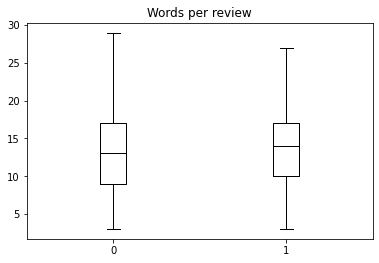

In [9]:
#check words in each review
df["Words per review"] = df["tweet"].str.split().apply(len)
df.boxplot("Words per review", by="label", grid=False, showfliers=False,color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [10]:
df["Words per review"].max()

34

In [11]:
# limit the length of a comment to 34 words 
# pad a comment with less than 34 words (add 0 vectors to the end).
max_seq = 34

In [12]:
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.tweet.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])

def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df):
    return torch.tensor(df['label'].values, dtype=torch.float32)

In [13]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

In [14]:
train_indices

tensor([[  101,  1165,  1142,  ...,     0,     0,     0],
        [  101,  1821, 26237,  ...,  2560,   111,  1821],
        [  101,   137,  4795,  ...,     0,     0,     0],
        ...,
        [  101,   137,  4795,  ...,     0,     0,     0],
        [  101,   137,  4795,  ...,     0,     0,     0],
        [  101,   137,  4795,  ...,     0,     0,     0]])

In [24]:
so = open("data.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [25]:
with torch.no_grad():
    x_train = bert_model(train_indices)
    x_val = bert_model(val_indices)
    x_test = bert_model(test_indices)

KeyboardInterrupt: 

In [ ]:
y_train = targets_to_tensor(df_train)
y_val = targets_to_tensor(df_val)
y_test = targets_to_tensor(df_test)

In [23]:
%%timeit 

x_train = bert_model(train_indices)

KeyboardInterrupt: 

In [ ]:
#check the first tweet
x_train[0]

In [ ]:
y_train[0]

### CNN

In [ ]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

### Training the model

In [ ]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [ ]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [ ]:
n_epochs = 10
batch_size = 8
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [ ]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [ ]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

        print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")